In [1]:
# Install required libraries
!pip install numpy pandas matplotlib tqdm scikit-learn seaborn opencv-python tensorflow
!pip install tf-keras-vis
!pip install lime



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import seaborn as sns
from glob import glob
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet169, preprocess_input
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from lime import lime_image
from skimage.segmentation import slic, mark_boundaries
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tf_keras_vis.utils.scores import BinaryScore
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

2024-09-04 22:54:54.139240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 22:54:54.154339: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 22:54:54.158843: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 22:54:54.173842: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Import warnings and suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Suppress TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Optional: Suppress TensorFlow deprecation warnings
import tensorflow as tf
tf.get_logger().setLevel('ERROR')


In [4]:

# 1. Data Loading and Label Assignment
train_dir = 'MURA-v1.1/train'
valid_dir = 'MURA-v1.1/valid'
category = 'XR_HUMERUS'

train_data = []
train_labels = []
valid_data = []
valid_labels = []

for label in ['negative', 'positive']:
    # Train data loading
    train_path = os.path.join(train_dir, category)
    train_file_paths = glob(os.path.join(train_path, '**', f'*_{label}'), recursive=True)
    for file_path in train_file_paths:
        for img in glob(os.path.join(file_path, '*.png')):
            train_data.append(img)
            train_labels.append(0 if label == 'negative' else 1)
    
    # Validation data loading
    valid_path = os.path.join(valid_dir, category)
    valid_file_paths = glob(os.path.join(valid_path, '**', f'*_{label}'), recursive=True)
    for file_path in valid_file_paths:
        for img in glob(os.path.join(file_path, '*.png')):
            valid_data.append(img)
            valid_labels.append(0 if label == 'negative' else 1)

# Convert to DataFrames
train_df = pd.DataFrame({'image_path': train_data, 'label': train_labels})
valid_df = pd.DataFrame({'image_path': valid_data, 'label': valid_labels})


In [5]:

# 2. Image Loading, Resizing, and Normalization
train_images = []
train_labels = []
valid_images = []
valid_labels = []

# Processing train images
for i, data in tqdm(train_df.iterrows(), total=len(train_df)):
    img = cv2.imread(data['image_path'])
    img = cv2.resize(img, (224, 224))
    train_images.append(img)
    train_labels.append(data['label'])

train_images = np.asarray(train_images).astype('float32')
train_labels = np.asarray(train_labels)

# Processing validation images
for i, data in tqdm(valid_df.iterrows(), total=len(valid_df)):
    img = cv2.imread(data['image_path'])
    img = cv2.resize(img, (224, 224))
    valid_images.append(img)
    valid_labels.append(data['label'])

valid_images = np.asarray(valid_images).astype('float32')
valid_labels = np.asarray(valid_labels)

# Normalization
mean = np.mean(train_images, axis=(0, 1, 2))
std = np.std(train_images, axis=(0, 1, 2))
train_images = (train_images - mean) / std
valid_images = (valid_images - mean) / std  # Normalize with the same mean and std



100%|██████████| 288/288 [00:00<00:00, 498.77it/s]


In [6]:
# 3. Data Augmentation and Generators Setup
# Convert labels to strings ('0' -> 'negative', '1' -> 'positive')
train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary',
    shuffle=False
)


Found 1272 validated image filenames belonging to 2 classes.
Found 288 validated image filenames belonging to 2 classes.


In [7]:
# 4. Calculate Class Weights for Imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")

Class weights: {0: 0.9450222882615156, 1: 1.0617696160267112}


In [8]:

# 4. Model Building: DenseNet169
input_shape = (224, 224, 3)
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')

# Fine-tuning the last 100 layers
for layer in base_model.layers[-100:]:
    layer.trainable = True

x = base_model.output
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=predictions)

# 5. Model Compilation
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'mse'])
checkpoint_path = 'best_model_densenet_humerus.keras'
# 6. Callbacks Setup
callbacks = [
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=0.0001, verbose=1)
]


2024-09-04 22:55:04.265790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43622 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:01:00.0, compute capability: 8.9


In [9]:

# 7. Model Training
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,  # Adjust based on your requirements
    callbacks=callbacks,
    class_weight=class_weight_dict
)


Epoch 1/5


I0000 00:00:1725490552.794986     697 service.cc:146] XLA service 0x757150001f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725490552.795037     697 service.cc:154]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-09-04 22:55:54.480990: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-04 22:56:00.519000: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
2024-09-04 22:57:42.956734: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion', 272 bytes spill stores, 272 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_117', 24 bytes spill stores, 24 bytes spill loads
ptx

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6654 - loss: 0.6275 - mse: 0.2180
Epoch 1: val_loss improved from inf to 0.41919, saving model to best_model_densenet_humerus.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 176s 125ms/step - accuracy: 0.6656 - loss: 0.6272 - mse: 0.2179 - val_accuracy: 0.8368 - val_loss: 0.4192 - val_mse: 0.1288 - learning_rate: 1.0000e-04
Epoch 2/5
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8091 - loss: 0.4442 - mse: 0.1399
Epoch 2: val_loss did not improve from 0.41919
159/159 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.8088 - loss: 0.4446 - mse: 0.1401 - val_accuracy: 0.7951 - val_loss: 0.4594 - val_mse: 0.1453 - learning_rate: 1.0000e-04
Epoch 3/5
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8171 - loss: 0.4123 - mse: 0.1304
Epoch 3: val_loss did not improve from 0.41919
159/159 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.8169 - loss: 0.4126 - mse: 0.1305 - val_accuracy: 0.8542 - val_loss: 0.4380 - val_mse: 0.1250 - learn

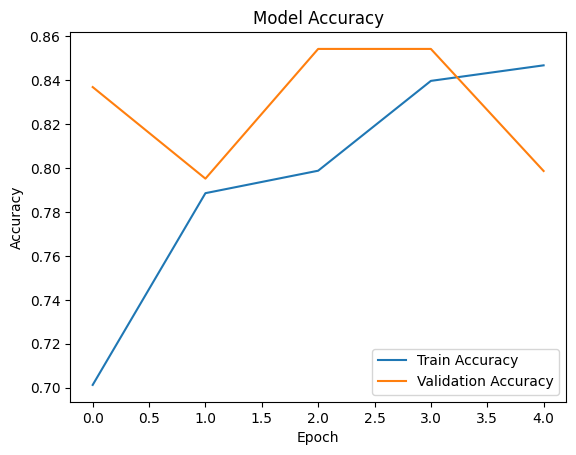

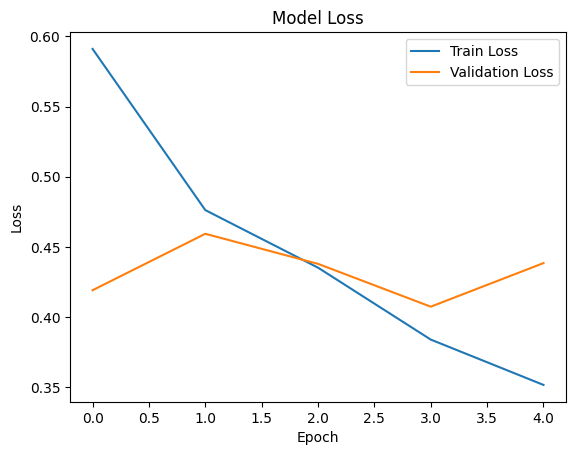

In [10]:
# 15. Plotting Model Training History (Accuracy and Loss)
# Accuracy Plot
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Loss Plot
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


In [11]:
# 9. Load the Best Model for Evaluation
best_model = load_model(checkpoint_path)

In [12]:
# 10. Evaluate the model on the validation set
valid_loss, valid_accuracy, valid_mse = best_model.evaluate(valid_generator)
print(f"Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy}, Validation MSE: {valid_mse}")

# 11. Predictions on the validation set
valid_predictions = best_model.predict(valid_generator)
valid_pred_labels = (valid_predictions > 0.5).astype(int)  # Threshold at 0.5


36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.8594 - loss: 0.3835 - mse: 0.1188
Validation Loss: 0.4074482023715973, Validation Accuracy: 0.8541666865348816, Validation MSE: 0.1221381276845932
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


Confusion Matrix:
 [[126  22]
 [ 20 120]]


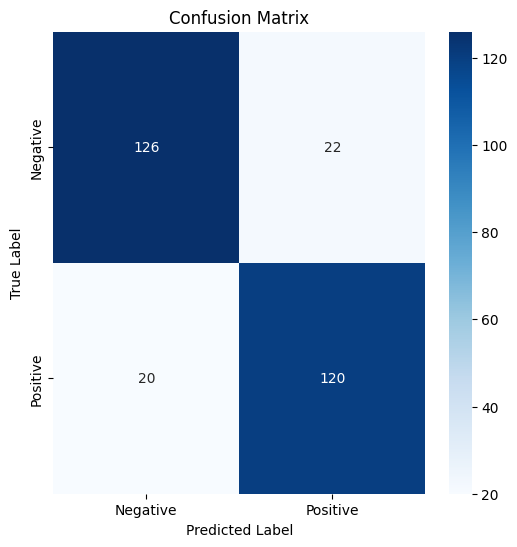

Classification Report:
               precision    recall  f1-score   support

    Negative       0.86      0.85      0.86       148
    Positive       0.85      0.86      0.85       140

    accuracy                           0.85       288
   macro avg       0.85      0.85      0.85       288
weighted avg       0.85      0.85      0.85       288



In [13]:
# 12. Confusion Matrix
conf_matrix = confusion_matrix(valid_generator.classes, valid_pred_labels)
print("Confusion Matrix:\n", conf_matrix)

# Plotting Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 13. Classification Report
class_report = classification_report(valid_generator.classes, valid_pred_labels, target_names=['Negative', 'Positive'])
print("Classification Report:\n", class_report)



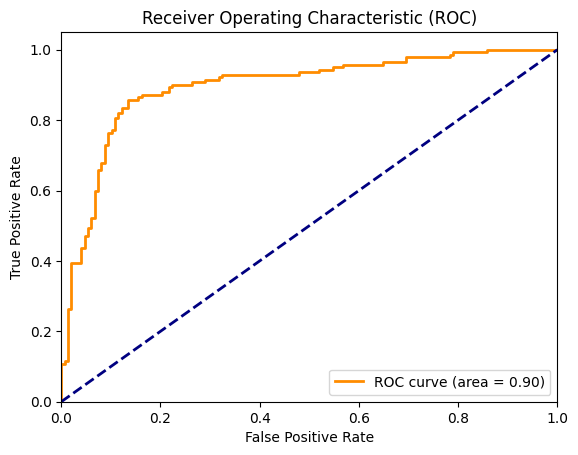

In [14]:
# 14. ROC and AUC Curve
fpr, tpr, _ = roc_curve(valid_generator.classes, valid_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()



In [15]:
# Model Building: ResNet50
input_shape = (224, 224, 3)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')

# Fine-tuning the last 50 layers for ResNet50
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

x = base_model.output
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=predictions)

# Model Compilation for ResNet50
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'mse'])

# Callbacks Setup (Saving Best Model for ResNet50)
checkpoint_path = 'best_model_humerus_resnet50.keras'
callbacks = [
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=0.0001, verbose=1)
]


In [16]:

# Model Training with Class Weights for ResNet50
history_resnet50 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,  # Adjust based on your requirements
    callbacks=callbacks,
    class_weight=class_weight_dict  # Apply class weights to handle imbalance
)


Epoch 1/5
157/159 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5267 - loss: 0.7703 - mse: 0.2793
Epoch 1: val_loss improved from inf to 0.61817, saving model to best_model_humerus_resnet50.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.5272 - loss: 0.7699 - mse: 0.2791 - val_accuracy: 0.6389 - val_loss: 0.6182 - val_mse: 0.2162 - learning_rate: 1.0000e-04
Epoch 2/5
156/159 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6118 - loss: 0.6813 - mse: 0.2395
Epoch 2: val_loss did not improve from 0.61817
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.6116 - loss: 0.6816 - mse: 0.2396 - val_accuracy: 0.5729 - val_loss: 0.7335 - val_mse: 0.2631 - learning_rate: 1.0000e-04
Epoch 3/5
157/159 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6322 - loss: 0.6490 - mse: 0.2283
Epoch 3: val_loss improved from 0.61817 to 0.57865, saving model to best_model_humerus_resnet50.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.6326 - loss: 0.6488 - mse: 0.2282 - va

In [17]:
# Load the Best ResNet50 Model for Evaluation
best_model_resnet50 = load_model(checkpoint_path)

In [18]:
# 10. Evaluate the model on the validation set
valid_loss, valid_accuracy, valid_mse = best_model_resnet50.evaluate(valid_generator)
print(f"Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy}, Validation MSE: {valid_mse}")

# 11. Predictions on the validation set
valid_predictions = best_model_resnet50.predict(valid_generator)
valid_pred_labels = (valid_predictions > 0.5).astype(int)  # Threshold at 0.5


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5567 - loss: 0.7092 - mse: 0.2527
Validation Loss: 0.5704660415649414, Validation Accuracy: 0.6666666865348816, Validation MSE: 0.19554050266742706
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step


Confusion Matrix:
 [[ 78  70]
 [ 26 114]]


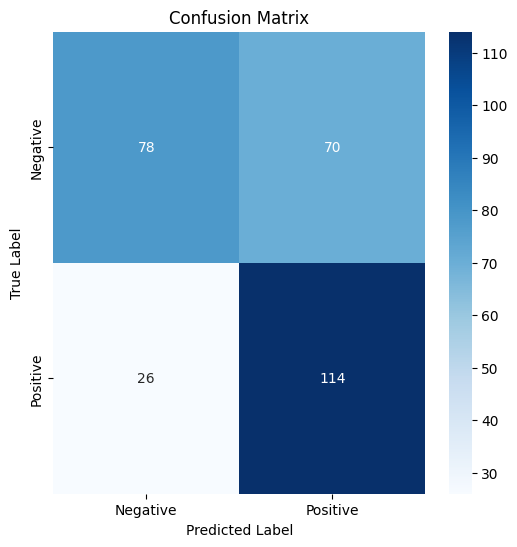

Classification Report:
               precision    recall  f1-score   support

    Negative       0.75      0.53      0.62       148
    Positive       0.62      0.81      0.70       140

    accuracy                           0.67       288
   macro avg       0.68      0.67      0.66       288
weighted avg       0.69      0.67      0.66       288



In [19]:
# 12. Confusion Matrix
conf_matrix = confusion_matrix(valid_generator.classes, valid_pred_labels)
print("Confusion Matrix:\n", conf_matrix)

# Plotting Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 13. Classification Report
class_report = classification_report(valid_generator.classes, valid_pred_labels, target_names=['Negative', 'Positive'])
print("Classification Report:\n", class_report)


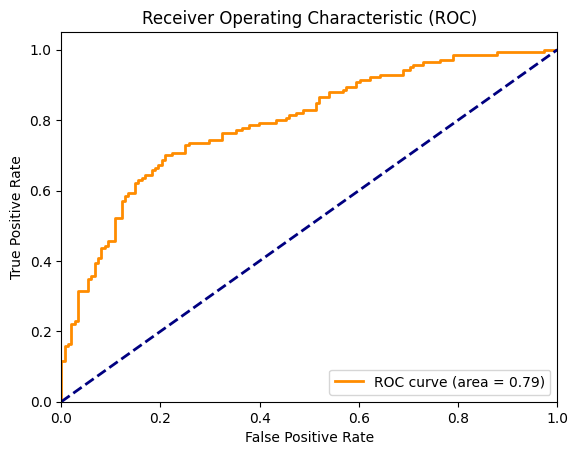

In [20]:
# 14. ROC and AUC Curve
fpr, tpr, _ = roc_curve(valid_generator.classes, valid_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [21]:

# 5. Model Building: InceptionV3
input_shape = (224, 224, 3)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')

# Fine-tuning the last 100 layers for InceptionV3
for layer in base_model.layers[:-100]:
    layer.trainable = False
for layer in base_model.layers[-100:]:
    layer.trainable = True

x = base_model.output
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=predictions)

# 6. Model Compilation for InceptionV3
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'mse'])

# 7. Callbacks Setup (Saving Best Model for InceptionV3)
checkpoint_path = 'best_model_humerus_inceptionv3.keras'
callbacks = [
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=0.0001, verbose=1)
]


In [22]:

# 8. Model Training with Class Weights for InceptionV3
history_inceptionv3 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,  # Adjust based on your requirements
    callbacks=callbacks,
    class_weight=class_weight_dict  # Apply class weights to handle imbalance
)



Epoch 1/5
157/159 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6562 - loss: 0.6521 - mse: 0.2274
Epoch 1: val_loss improved from inf to 0.58265, saving model to best_model_humerus_inceptionv3.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.6564 - loss: 0.6518 - mse: 0.2272 - val_accuracy: 0.7396 - val_loss: 0.5826 - val_mse: 0.1889 - learning_rate: 1.0000e-04
Epoch 2/5
156/159 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7668 - loss: 0.5110 - mse: 0.1699
Epoch 2: val_loss did not improve from 0.58265
159/159 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.7663 - loss: 0.5113 - mse: 0.1701 - val_accuracy: 0.7257 - val_loss: 0.5922 - val_mse: 0.1857 - learning_rate: 1.0000e-04
Epoch 3/5
156/159 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7905 - loss: 0.4666 - mse: 0.1484
Epoch 3: val_loss did not improve from 0.58265
159/159 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.7901 - loss: 0.4668 - mse: 0.1486 - val_accuracy: 0.7569 - val_loss: 0.6060 - val_mse: 0.1

In [23]:
# Load the Best InceptionV3 Model for Evaluation
best_model_inceptionv3 = load_model(checkpoint_path)

In [24]:
# 10. Evaluate the model on the validation set
valid_loss, valid_accuracy, valid_mse = best_model_inceptionv3.evaluate(valid_generator)
print(f"Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy}, Validation MSE: {valid_mse}")

# 11. Predictions on the validation set
valid_predictions = best_model_inceptionv3.predict(valid_generator)
valid_pred_labels = (valid_predictions > 0.5).astype(int)  # Threshold at 0.5


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7322 - loss: 0.5822 - mse: 0.1935
Validation Loss: 0.5826470851898193, Validation Accuracy: 0.7395833134651184, Validation MSE: 0.18888048827648163
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step


Confusion Matrix:
 [[110  38]
 [ 37 103]]


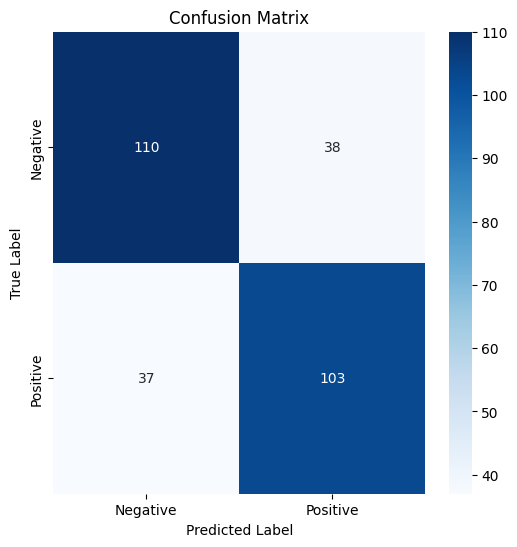

Classification Report:
               precision    recall  f1-score   support

    Negative       0.75      0.74      0.75       148
    Positive       0.73      0.74      0.73       140

    accuracy                           0.74       288
   macro avg       0.74      0.74      0.74       288
weighted avg       0.74      0.74      0.74       288



In [25]:
# 12. Confusion Matrix
conf_matrix = confusion_matrix(valid_generator.classes, valid_pred_labels)
print("Confusion Matrix:\n", conf_matrix)

# Plotting Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 13. Classification Report
class_report = classification_report(valid_generator.classes, valid_pred_labels, target_names=['Negative', 'Positive'])
print("Classification Report:\n", class_report)


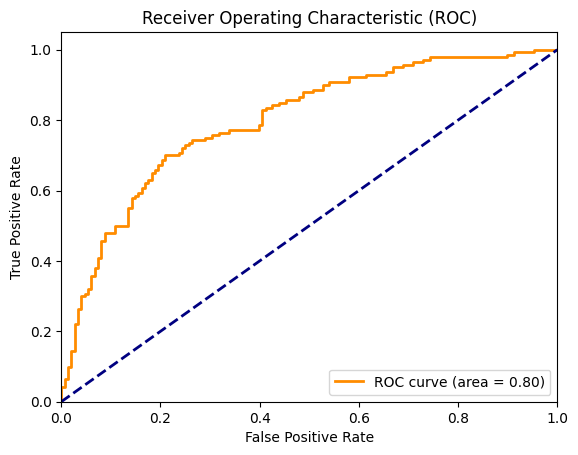

In [26]:
# 14. ROC and AUC Curve
fpr, tpr, _ = roc_curve(valid_generator.classes, valid_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


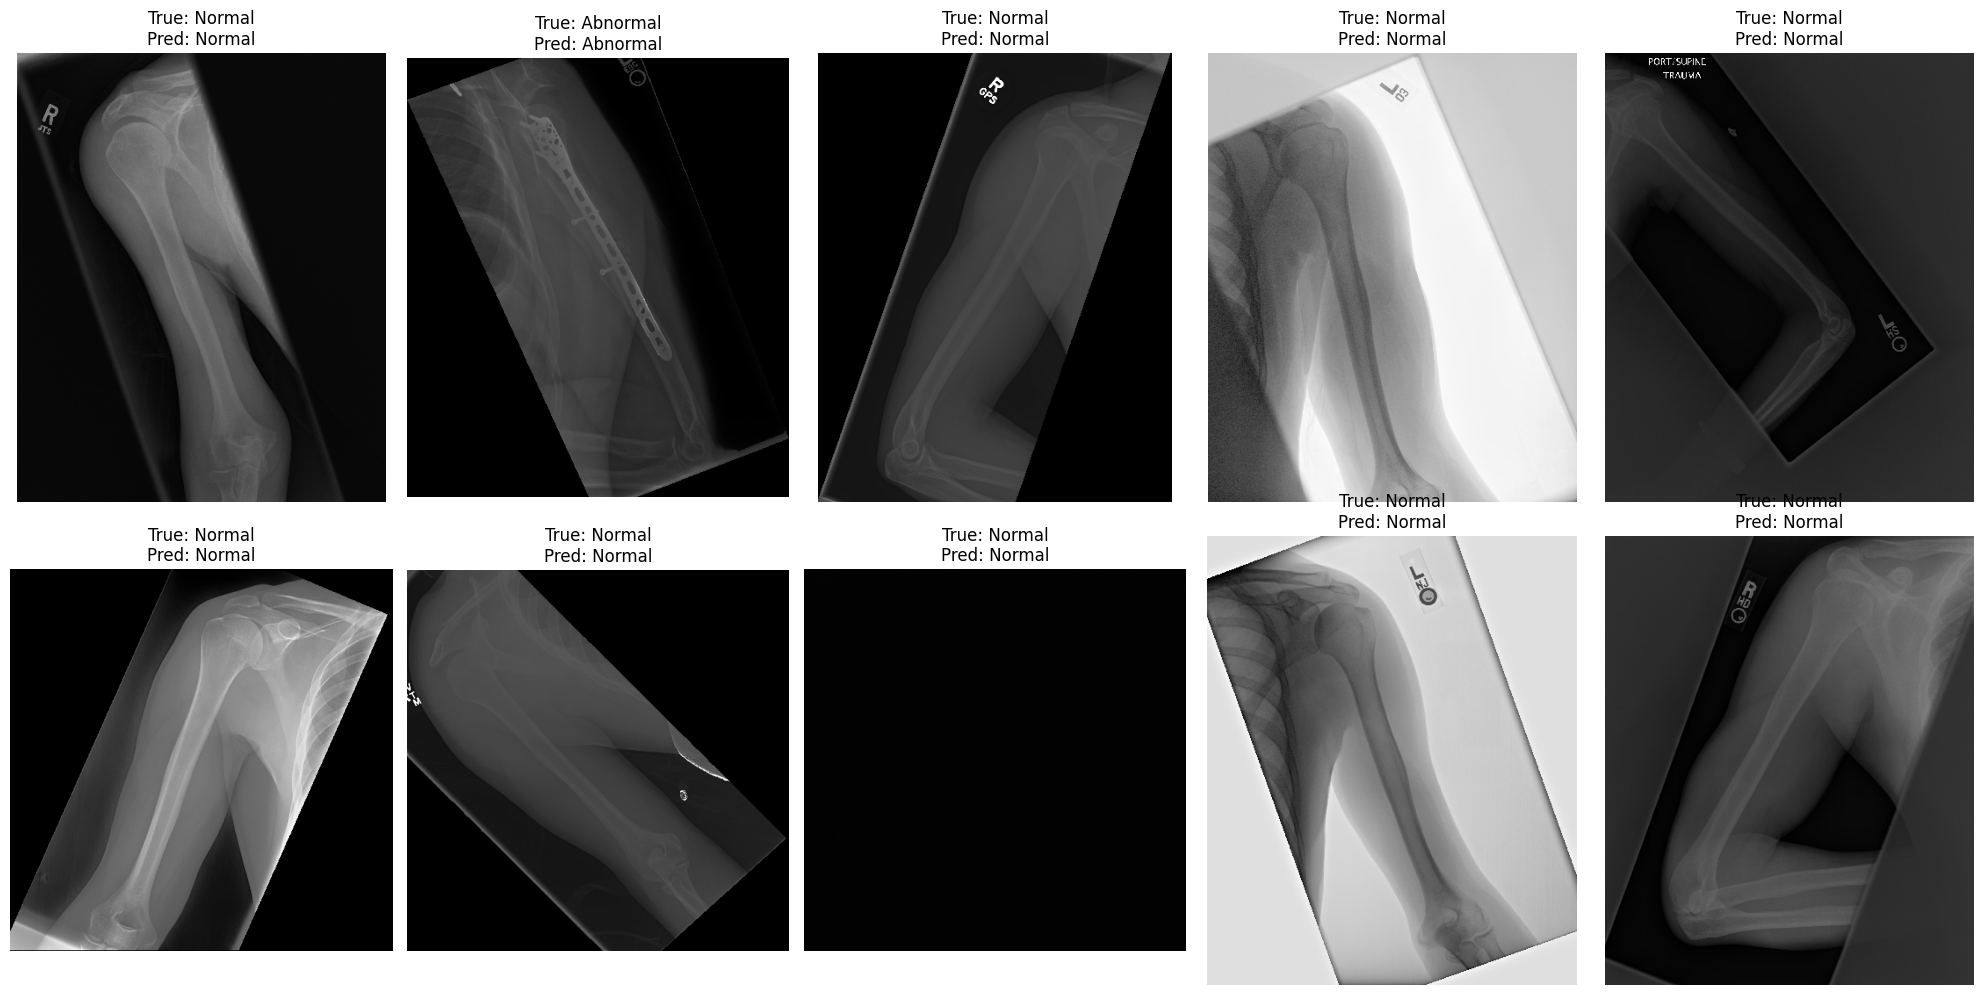

In [19]:
import random

# Assuming you have already trained the DenseNet169 model and saved it as 'best_model.keras'
# Load the best saved model
best_model = load_model('best_model_densenet_humerus.keras')

# Load the test dataset
test_dir = 'MURA-v1.1/valid'
test_data = []
test_labels = []

for label in ['negative', 'positive']:
    # Test data loading
    test_path = os.path.join(test_dir, category)
    test_file_paths = glob(os.path.join(test_path, '**', f'*_{label}'), recursive=True)
    for file_path in test_file_paths:
        for img in glob(os.path.join(file_path, '*.png')):
            test_data.append(img)
            test_labels.append(0 if label == 'negative' else 1)  # 0 for normal, 1 for abnormal

# Create DataFrame for test data
test_df = pd.DataFrame({'image_path': test_data, 'label': test_labels})

# Function to load and preprocess image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = img.astype('float32')
    img = (img - mean) / std  # Normalize using training mean and std
    return img

# Randomly select 10 images from the test data
random_indices = random.sample(range(len(test_df)), 10)
random_images = test_df.iloc[random_indices]

# Plot the images with true and predicted labels
plt.figure(figsize=(20, 10))

for i, row in enumerate(random_images.itertuples(), start=1):
    # Preprocess the image
    image_path = row.image_path
    true_label = 'Normal' if row.label == 0 else 'Abnormal'
    img = preprocess_image(image_path)
    
    # Reshape for prediction
    img_batch = np.expand_dims(img, axis=0)
    
    # Predict using the best model
    prediction = best_model.predict(img_batch)
    predicted_label = 'Normal' if prediction < 0.5 else 'Abnormal'
    
    # Read image for display
    original_img = cv2.imread(image_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    # Plot the image
    plt.subplot(2, 5, i)
    plt.imshow(original_img)
    plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

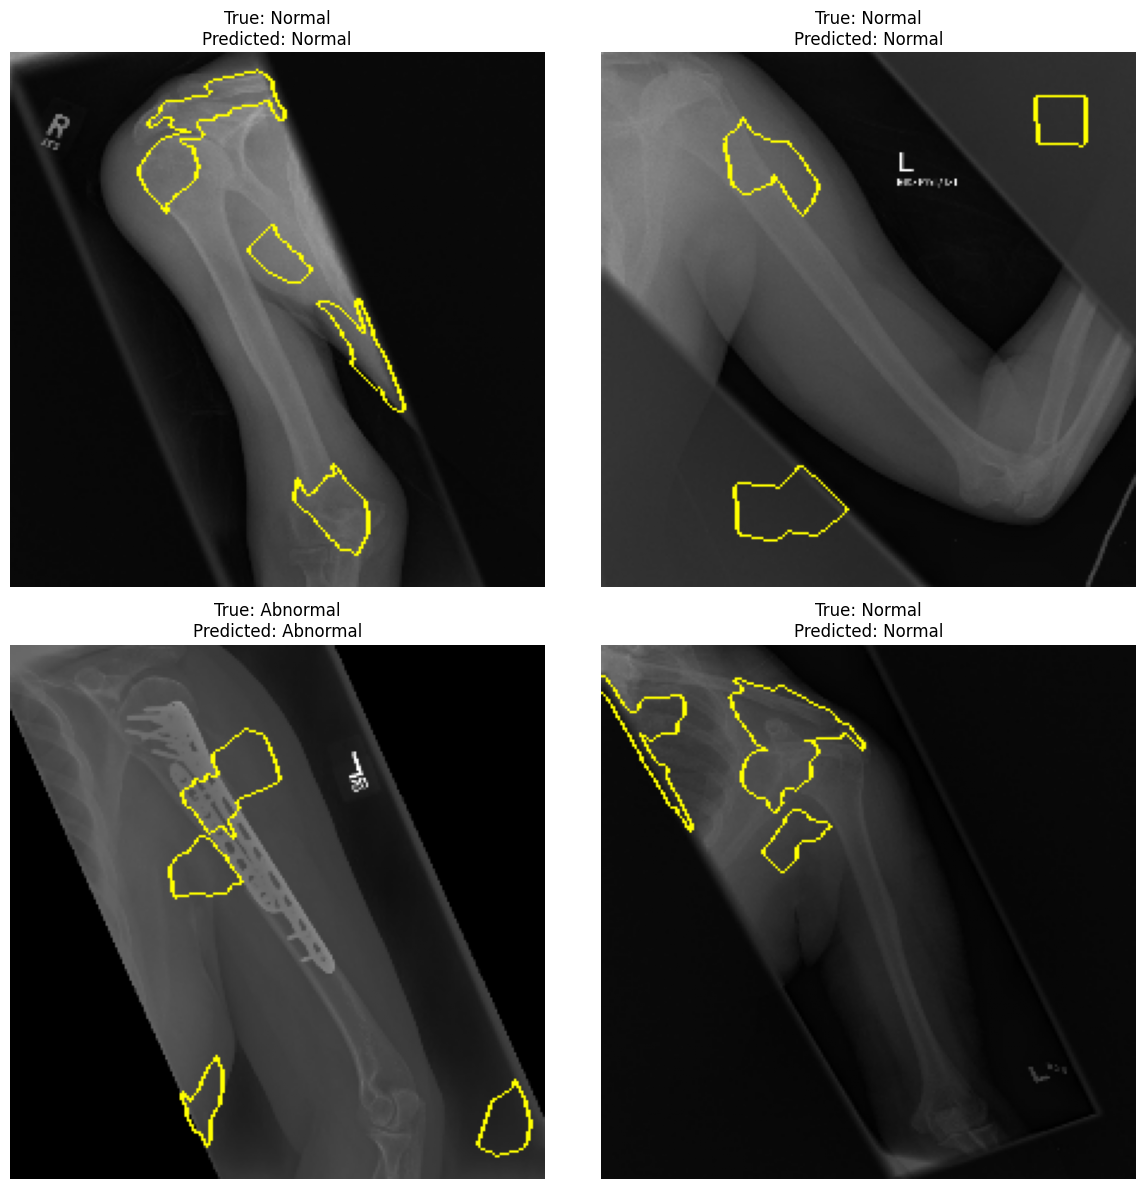

In [20]:

# Function to preprocess image for LIME
def preprocess_lime_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Resize to 224x224 for LIME
    return img / 255.0  # LIME expects input in [0, 1] range

# Predict function for LIME
def predict_fn(images):
    processed_images = np.array([preprocess_input(img) for img in images])  # Preprocess input for the model
    return best_model.predict(processed_images)

# Custom segmentation function for LIME using SLIC (increase the area by adjusting segments and compactness)
def slic_segmentation(image):
    return slic(image, n_segments=150, compactness=5, sigma=1)  # Fewer segments (150), less compact (5)

# Select 4 random images from the test set
random_indices = random.sample(range(len(test_df)), 4)

# Prepare a figure for displaying the results
plt.figure(figsize=(12, 12))

# Loop through the 4 selected images
for i, idx in enumerate(random_indices):
    image_path = test_df.iloc[idx]['image_path']
    true_label = 'Normal' if test_df.iloc[idx]['label'] == 0 else 'Abnormal'
    
    # Preprocess the image for LIME
    image = preprocess_lime_image(image_path)

    # Use LIME to explain the prediction with the SLIC segmentation
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        image, 
        predict_fn, 
        top_labels=2, 
        hide_color=0, 
        num_samples=2000,  # High number of samples for accurate perturbations
        segmentation_fn=slic_segmentation  # Use SLIC segmentation
    )

    # Get explanation for the top label (predicted label)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

    # Get the predicted label
    img_for_pred = np.expand_dims(preprocess_input(cv2.resize(cv2.imread(image_path), (224, 224))), axis=0)
    predicted_label = 'Normal' if best_model.predict(img_for_pred) < 0.5 else 'Abnormal'

    # Load the original image and resize it to 224x224 to match the LIME output
    original_img = cv2.imread(image_path)
    original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
    original_img_rgb_resized = cv2.resize(original_img_rgb, (224, 224))  # Resize to 224x224

    # Superimpose the LIME explanation outline on the resized original image
    superimposed_img = mark_boundaries(original_img_rgb_resized / 255.0, mask)

    # Plot each image with its LIME explanation
    plt.subplot(2, 2, i+1)  # 2x2 grid for 4 images
    plt.imshow(superimposed_img)
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}", fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


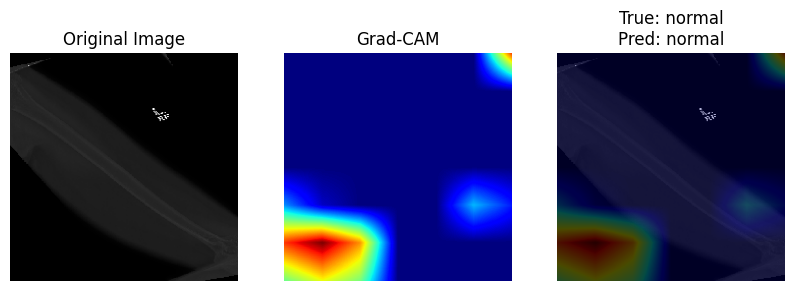

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


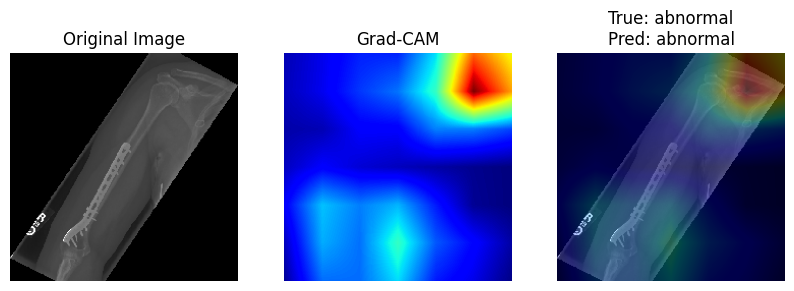

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


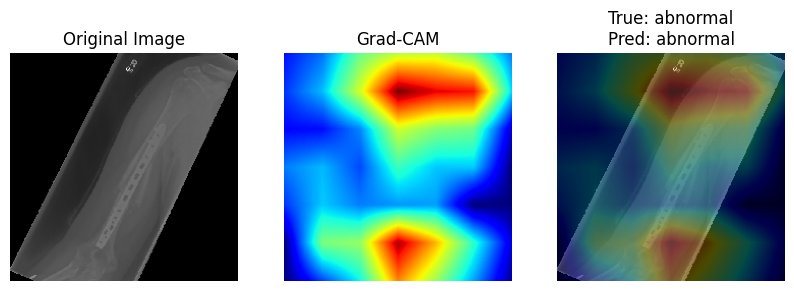

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


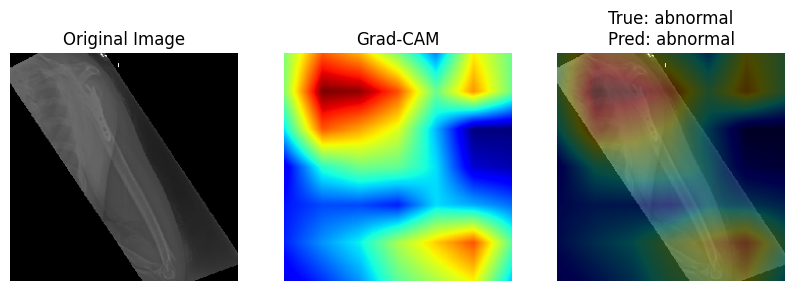

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


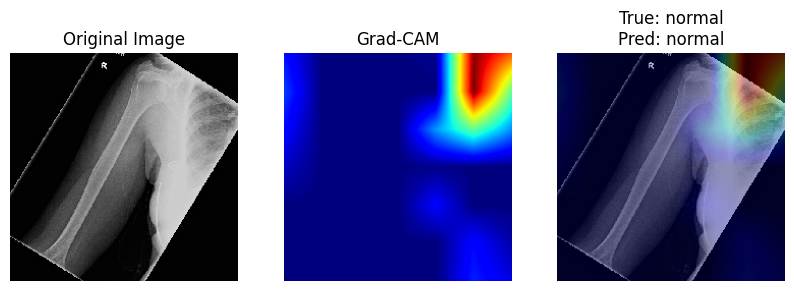

In [21]:


# Load the best saved DenseNet169 model
model = load_model(checkpoint_path)  # Ensure checkpoint_path points to the saved best model

# Modify the model to replace the final activation with linear for Grad-CAM
replace2linear = ReplaceToLinear()
score = BinaryScore(1)  # For binary classification, label 1 indicates 'abnormal'

# Create the GradCAM object
gradcam = Gradcam(model, model_modifier=replace2linear, clone=False)


# Function to generate Grad-CAM visualization with a more subtle heatmap overlay
def generate_gradcam_visualization(img_path, model, gradcam, true_label, alpha=0.3):
    # Load and preprocess the image
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Generate Grad-CAM heatmap
    cam = gradcam(score, x)
    heatmap = np.uint8(255 * cam[0])

    # Get model prediction
    prediction = model.predict(x)
    predicted_label = 'abnormal' if prediction > 0.5 else 'normal'

    # Plot original image, heatmap, and predicted label
    plt.figure(figsize=(10, 4))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img)
    plt.axis('off')

    # Grad-CAM heatmap
    plt.subplot(1, 3, 2)
    plt.title('Grad-CAM')
    plt.imshow(heatmap, cmap='jet')
    plt.axis('off')

    # Original Image with Heatmap Overlay (more subtle overlay with alpha adjustment)
    plt.subplot(1, 3, 3)
    plt.title(f'True: {true_label}\nPred: {predicted_label}')
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=alpha)  # Subtle overlay with adjustable alpha
    plt.axis('off')

    plt.show()

# Randomly select 5 images from the validation dataset
random_indices = random.sample(range(len(valid_df)), 5)
selected_images = valid_df.iloc[random_indices]

# Generate Grad-CAM visualizations for selected images with more subtle overlays
for i, row in selected_images.iterrows():
    img_path = row['image_path']
    true_label = 'abnormal' if int(row['label']) == 1 else 'normal'
    generate_gradcam_visualization(img_path, model, gradcam, true_label, alpha=0.3)  # Adjust alpha for subtlety
